##Imports

In [1]:
%matplotlib inline

from __future__ import absolute_import, print_function, unicode_literals, division
from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import random as rand
import copy
from pylab import rcParams

##RBM Implementation

In [2]:
class RBM(object):
    """
    Implementation of Restricted Boltzmann Machine for binary prediction
    
    Inputs:
    Data
    Number of hidden and visible states
    Learning rate, default set to 0.1
    Number of Epochs to train for
    Option for which unit to use, either "binary" or "continuous"
    
    Outputs:
    Weight matrix
    Epoch number and error
    """

    def __init__(self, data, num_visible, num_hidden, num_epochs, learning_rate=0.1, unit="binary"):
        
        self.data = data
        self.num_data = data.shape[0]
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.unit = unit

        # weight matrix first row and first column represent the bias
        self.weights = np.random.rand(self.num_visible, self.num_hidden) 
        self.weights = np.insert(self.weights, 0, 0, axis = 0)
        self.weights = np.insert(self.weights, 0, 0, axis = 1)
        
    def _relu(self, x):
        """
        Rectifier continuous Activation Function
        """
        return np.maximum(0,x)
        
    def _sigmoid(self, x):
        """
        Sigmoid Binary Activation function
        """
        return 1.0/(1.0+np.exp(-x))
    
    def _gen_prob(self,a,b):
        
        if self.unit == "binary":
            return self._sigmoid(np.dot(a,b))
        elif self.unit == "continuous":
            return self._relu(np.dot(a,b))
        else:
            raise "Unknown Unit"
    
    def _gen_assoc(self,a):
        probs = self._gen_prob(a,self.weights)
        #print(probs)
        return np.dot(a.T,probs)
    
    def _sample_v_given_h(self, h):  # h does not contain bias
        probs = self._gen_prob(self.weights, np.insert(h,0,1))
        sample = probs > np.random.rand(self.num_visible + 1)
        return sample[1:]
    
    def _sample_h_given_v(self, v):  # v does not contain bias
        probs = self._gen_prob(self.weights.T, np.insert(v,0,1, axis = 1).T)
        sample = probs > np.random.rand(self.num_hidden + 1, self.num_data)
        return sample[1:].T
    
    def _sample_h_given_v_nontrain(self, v):  # v does not contain bias
        probs = self._gen_prob(self.weights.T, np.insert(v,0,1).T)
        sample = probs > np.random.rand(self.num_hidden + 1)
        return sample[1:]
    
    def train(self, up_probs, error_array, epoch):
        """
        Trains the RBM, calling CDk or PCDk depending on user input
        """
        up_associations = self._gen_assoc(self.data)
        up_states = up_probs > np.random.rand(self.num_data, self.num_hidden + 1)

        # CD-k negative phase
        down_probs = self._gen_prob(up_states,self.weights.T)
        down_probs[:,0] = 1 
        down_associations = self._gen_assoc(down_probs)

        # Update weights iteratively based on positive and negative phases
        self.weights += self.learning_rate * \
            ((up_associations - down_associations)/self.num_data)

        # Calculate error
        error = np.sum((self.data - down_probs) ** 2)

        error_array.append(error)
        
        return down_probs, error

    
    def PCDk(self):
        """
        Implementation of Persistent CD-k iterative training algorithm
        
        aims to sample almost directly from the model distribution to better approximate
        the likelihood gradient when the mixing is low
        
        Based on this work: http://www.cs.toronto.edu/~tijmen/pcd/pcd.pdf
        """
        max_epochs = self.num_epochs + 1
        
        # array to keep track of errors for plotting
        error_array = []
        
        down_probs = []
        
        # insert the bias layer into the data
        self.data = np.insert(self.data, 0, 1, axis=1)
        
        # iterate for each epoch
        for epoch in xrange(0, max_epochs):
            
            # CD-k positive phase
            if epoch == 0:
                up_probs = self._gen_prob(self.data,self.weights)
            else:
                up_probs = self._gen_prob(down_probs,self.weights)
                
            down_probs, error = self.train(up_probs, error_array, epoch)
            
            # Print information about the last epoch
            if epoch == self.num_epochs:
                print("Layers: ", self.num_hidden, "Rate: ", self.learning_rate, "Epoch: ", epoch, ", Error: ", error)
                return down_probs, error_array
    
    def CDk(self):
        """
        Implementation of CD-k iterative training algorithm
        """
        max_epochs = self.num_epochs + 1
        
        # array to keep track of errors for plotting
        error_array = []
        
        # insert the bias layer into the data
        self.data = np.insert(self.data, 0, 1, axis=1)
        
        # iterate for each epoch
        for epoch in xrange(0, max_epochs):
            
            # CD-k positive phase
            up_probs = self._gen_prob(self.data,self.weights)
            
            down_probs, error = self.train(up_probs, error_array, epoch)
            
            # Print information about the last epoch
            if epoch == self.num_epochs:
                print("Layers: ", self.num_hidden, "Rate: ", self.learning_rate, "Epoch: ", epoch, ", Error: ", error)
                return down_probs, error_array


##Toy Datatset of Movie Ratings

In [18]:
alice = {"Interstellar":1, "Whiplash":1, "Selma":0, "Lego Movie":0, "Birdman":0}
eric = {"Interstellar":0, "Whiplash":0, "Selma":0, "Lego Movie":1, "Birdman":0}
nancy = {"Interstellar":1, "Whiplash":1, "Selma":1, "Lego Movie":0, "Birdman":1}
sarah = {"Interstellar":0, "Whiplash":1, "Selma":0, "Lego Movie":0, "Birdman":1}
mike = {"Interstellar":1, "Whiplash":1, "Selma":1, "Lego Movie":1, "Birdman":1}
bob = {"Interstellar":0, "Whiplash":1, "Selma":1, "Lego Movie":0, "Birdman":1}

toy_data = {"alice":alice, "eric":eric, "nancy":nancy}#, "sarah":sarah} "mike":mike, "bob":bob}

toy_data = pd.DataFrame.from_dict(toy_data)
toy_data.head()

,alice,eric,nancy
Birdman,0,0,1
Interstellar,1,0,1
Lego Movie,0,1,0
Selma,0,0,1
Whiplash,1,0,1


In [8]:
toy_data_array = np.array(toy_data)
print(toy_data_array)
print(toy_data_array.shape)

[[0 0 1]
 [1 0 1]
 [0 1 0]
 [0 0 1]
 [1 0 1]]
(5, 3)


####Run RBM on Toy Dataset-Binary

In [19]:
visible_units = toy_data_array.shape[1]
epochs = 100
hidden_units = 1000
learning_rate = 0.1

r = RBM(toy_data_array, visible_units, hidden_units, epochs, learning_rate, "binary")
sample, error = r.CDk()
print(r.weights)
print(sample[:,1:])

Units:  1000 Rate:  0.1 Epoch:  100 , Error:  1.63292125482e-05
[[ 0.07389049 -0.21650186 -0.15323567 ..., -0.16416733 -0.18542582
  -0.09481734]
 [-0.32248223  0.15422403 -0.51298284 ...,  0.13170697  0.34270343
   0.47964674]
 [-0.24352931  0.2868032   0.35992841 ..., -0.50732662 -0.5836021
  -0.47715028]
 [-0.29300231  0.26808497  0.30733335 ...,  0.40080893  0.38993252
  -0.15733346]]
[[  1.59595963e-03   6.17545683e-12   9.99999976e-01]
 [  9.99999666e-01   1.65839486e-09   9.98536063e-01]
 [  3.40545792e-03   9.99997604e-01   7.84540063e-11]
 [  1.65588568e-05   4.59768465e-09   9.99999090e-01]
 [  9.99816548e-01   1.54167316e-08   9.99910921e-01]]


##Fetch MNIST Dataset

In [3]:
DATA_PATH = '~/data'
mnist = fetch_mldata('MNIST original', data_home=DATA_PATH)
print(mnist.data.shape)

(70000, 784)


#### Example Image

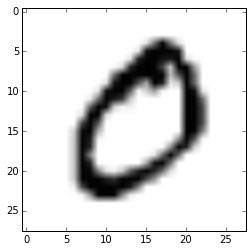

In [4]:
mnist_data_array = mnist.data
plt.imshow(mnist_data_array[0].reshape(28, 28), cmap = 'Greys')
plt.show()

#### Standard basic RBMs take binary inputs only, so we'll convert the image to a binary matrix

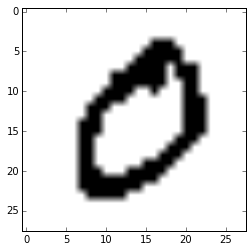

In [5]:
for img in mnist_data_array:
    # set arbitrary, reasonable cutoff
    img[img < 100] = 0
    img[img > 0] = 1

# sample image after converting to binary matrix
plt.imshow(mnist_data_array[0].reshape(28, 28), cmap = 'Greys')
plt.show()

#### Run RBM on MNIST dataset- Binary

In [66]:
visible_units = mnist_data_array.shape[1]
epochs = 2
hidden_layers = 100
learning_rate = 0.1

r = RBM(mnist_data_array, visible_units, hidden_layers, epochs, learning_rate, "binary")
sample = r.CDk()
print(r.weights)

Layers:  100 Rate:  0.1 Epoch:  2 , Error:  47051392.9998
[[  1.09832078e-02  -3.05998083e-08  -1.15854314e-09 ...,  -5.11625027e-08
   -2.32179177e-09  -1.52353700e-08]
 [ -5.00000000e-02   4.78407353e-01   5.47273097e-01 ...,   4.89116908e-01
   -2.26888789e-01  -3.96658721e-02]
 [ -5.00000000e-02   1.56069776e-01   1.58229889e-01 ...,   2.70156173e-02
    4.30748351e-01  -1.43817220e-02]
 ..., 
 [ -5.00000000e-02   6.44083594e-01   2.54061003e-01 ...,   3.56758606e-02
    1.41743342e-01  -2.79870597e-01]
 [ -5.00000000e-02  -2.47455579e-01   1.72936650e-02 ...,   1.45933683e-01
   -1.28937378e-01   4.01209966e-01]
 [ -5.00000000e-02   1.15125760e-01   3.78043806e-01 ...,   6.80936196e-01
    3.97513493e-02   4.57204893e-01]]


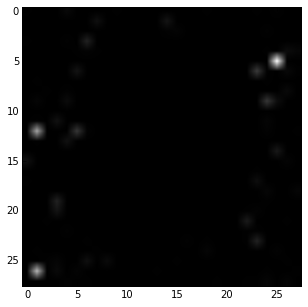

In [67]:
plt.imshow(sample[0][11][1:].reshape(28, 28), cmap = 'Greys')
plt.show()

In [42]:
visible_units = mnist_data_array.shape[1]
epochs = 2
hidden_layers = 100
learning_rate = 0.1

r = RBM(mnist_data_array, visible_units, hidden_layers, epochs, learning_rate, "binary")
samplep = r.PCDk()
print(r.weights)

Layers:  100 Rate:  0.1 Epoch:  2 , Error:  47051392.9997
[[  1.09832078e-02  -7.03154281e-09  -4.63209809e-10 ...,  -4.55199805e-09
   -1.20481587e-08  -1.62984187e-08]
 [ -5.00000000e-02   2.39200706e-01   6.40149927e-01 ...,  -1.36523094e-01
    1.51805248e-01   4.51329060e-01]
 [ -5.00000000e-02   6.39382292e-01   6.47009078e-01 ...,  -3.70215108e-02
    1.89380498e-02   6.10168703e-01]
 ..., 
 [ -5.00000000e-02  -1.87783061e-02   3.79520605e-01 ...,  -3.61274166e-02
    5.24576742e-01  -4.10433973e-02]
 [ -5.00000000e-02   6.49472541e-01   6.84274722e-01 ...,  -7.07206289e-02
    6.15139304e-01   4.45650863e-01]
 [ -5.00000000e-02   5.36478315e-01   5.11977819e-01 ...,   1.54482046e-02
    4.99731647e-01  -4.57212941e-02]]


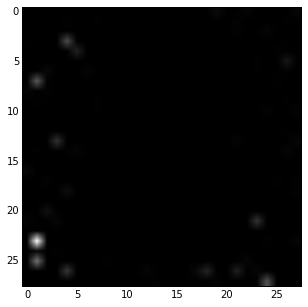

In [43]:
plt.imshow(samplep[0][11][1:].reshape(28, 28), cmap = 'Greys')
plt.show()
#imshow(sample[0][images[i]][1:].reshape(28,28), cmap="Greys")

#### Run RBM on MNIST dataset- Continuous

In [41]:
visible_units = mnist_data_array.shape[1]
epochs = 2
hidden_layers = 100
learning_rate = 0.4

r = RBM(mnist_data_array, visible_units, hidden_layers, epochs, learning_rate, "continuous")
sample = r.CDk()
print(r.weights)

[[  0.          65.84926913  67.29953782 ...,  64.88554593  66.15628112
   66.00843081]
 [  0.          71.60360011  71.73313428 ...,  68.45525114  74.81043417
   70.56952587]
 [  0.          74.65735131  84.12595338 ...,  77.07374418  81.58872707
   82.57988655]
 ..., 
 [  0.          60.97666457  61.65345284 ...,  56.3712398   61.51976122
   64.28922338]
 [  0.          55.15933368  56.71853985 ...,  55.26107367  59.08719703
   57.71670147]
 [  0.          61.81914625  68.2589828  ...,  62.80091227  64.59463101
   66.24153477]]
[[     0.          19268.18976694  19046.49213555 ...,  19240.41153741
   19468.13612836  19858.64307694]
 [     0.          19268.18976694  19046.49213555 ...,  19240.41153741
   19468.13612836  19858.64307694]
 [     0.          19268.18976694  19046.49213555 ...,  19240.41153741
   19468.13612836  19858.64307694]
 ..., 
 [     0.          19268.18976694  19046.49213555 ...,  19240.41153741
   19468.13612836  19858.64307694]
 [     0.          19268.18976694

##Fetch Faces In The Wild Dataset

In [30]:
lfw_people = fetch_lfw_people(min_faces_per_person=70)
print(lfw_people.data.shape)
print(lfw_people.images.shape)

(1288, 2914)
(1288, 62, 47)


####Example Image

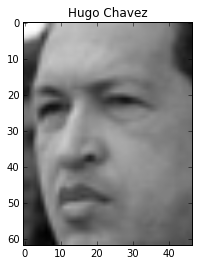

In [33]:
faces_data_array = lfw_people.data
person = lfw_people.target
names = lfw_people.target_names

plt.imshow(faces_data_array[0].reshape(62,47), cmap=plt.cm.gray)
plt.title(names[person][0])
plt.show()

####Run RBM on Faces dataset-Continous

## Parameter Optimization using Cross Validation 

In [6]:
visible_units = mnist_data_array.shape[1]
max_epochs = 100
max_hidden_units = 11
max_learning_rate = 10

# cross validation
for hidden_units in xrange(1, max_hidden_units):
    for learning_rate in xrange(1, max_learning_rate):
        r = RBM(mnist_data_array, visible_units, 100*hidden_units, max_epochs, learning_rate/float(10))
        r.CDk()

Layers:  100 Rate:  0.1 Epoch:  100 , Error:  2924093.40296
Layers:  100 Rate:  0.2 Epoch:  100 , Error:  2590810.49885
Layers:  100 Rate:  0.3 Epoch:  100 , Error:  2419529.13044
Layers:  100 Rate:  0.4 Epoch:  100 , Error:  2953467.43609
Layers:  100 Rate:  0.5 Epoch:  100 , Error:  3080931.4865
Layers:  100 Rate:  0.6 Epoch:  100 , Error:  4649189.5418
Layers:  100 Rate:  0.7 Epoch:  100 , Error:  13714638.9772
Layers:  100 Rate:  0.8 Epoch:  100 , Error:  7172705.9948
Layers:  100 Rate:  0.9 Epoch:  100 , Error:  2575479.49496
Layers:  200 Rate:  0.1 Epoch:  100 , Error:  2379539.26787
Layers:  200 Rate:  0.2 Epoch:  100 , Error:  2171885.90979
Layers:  200 Rate:  0.3 Epoch:  100 , Error:  2084536.22896
Layers:  200 Rate:  0.4 Epoch:  100 , Error:  2846840.70569
Layers:  200 Rate:  0.5 Epoch:  100 , Error:  3097520.46994
Layers:  200 Rate:  0.6 Epoch:  100 , Error:  4288084.20697
Layers:  200 Rate:  0.7 Epoch:  100 , Error:  13712224.226
Layers:  200 Rate:  0.8 Epoch:  100 , Error:

#### Can also read our results from this text file

In [6]:
with open("crossval.txt") as f:
    content = f.readlines()
    sep = "r:"
    for line in content:
        print((line.rstrip()).split(sep, 1)[1])

  2924093.40296
  2590810.49885
  2419529.13044
  2953467.43609
  3080931.4865
  4649189.5418
  13714638.9772
  7172705.9948
  2575479.49496
  2379539.26787
  2171885.90979
  2084536.22896
  2846840.70569
  3097520.46994
  4288084.20697
  13712224.226
  13710518.5787
  2787005.78354
  2046802.3657
  1926056.93459
  1981525.25896
  2847273.69118
  3006773.68455
  4303682.89814
  13708779.3511
  13704324.2519
  2887347.75473
  1823233.01865
  1811815.23658
  1953322.35286
  2823419.13375
  3112308.75366
  4004538.25567
  13707391.2001
  5856242.82855
  2938582.10929
  1665085.94043
  1693769.41771
  1994401.03571
  2757157.05699
  3040905.88826
  4021528.28946
  13701012.5046
  7713463.47162
  3019489.99364
  1517256.18041
  1623650.97196
  2031870.18235
  2673211.05165
  3029560.25283
  4120259.65396
  12973760.2982
  13708310.9063
  3061058.60966
  1392642.47766
  1575408.88239
  2006883.43541
  2577767.73441
  3028673.28099
  4208326.47134
  13697172.7609
  13702494.5764
  3120012.078

In [8]:
cv = pd.read_csv("crossval.csv")
cv.head()

,Hidden Units,Learning Rate,Error
0,100,0.1,2924093.403
1,100,0.2,2590810.499
2,100,0.3,2419529.130
3,100,0.4,2953467.436
4,100,0.5,3080931.487


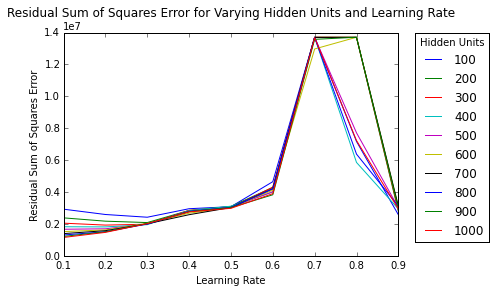

In [9]:
for key, grp in cv.groupby(['Hidden Units']):
    plt.plot(grp['Learning Rate'], grp['Error'], label=key)

plt.legend(title='Hidden Units',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Residual Sum of Squares Error for Varying Hidden Units and Learning Rate', y=1.05)
plt.xlabel('Learning Rate')
plt.xlim([0.1, 0.9])
plt.ylabel('Residual Sum of Squares Error') 
plt.show()

## Visualizing our RBM Output

In [6]:
def rbm_and_plot(data, num_hidden, epochs, learning_rate=.3, persistent=False):
    """
    Trains and plots RBM output on MNIST dataset
    
    Inputs:
    data 
    number of hidden states
    number of epochs
    RBM learning rate, default set to 0.3
    
    Outputs:
    Trained RBM weight matrix
    Example of RBM prediction on an example digit from the MNIST dataset
    Graph of error as a function of epoch
    """
    
    # Set up RBM
    num_visible = data.shape[1]
    r = RBM(data, num_visible, num_hidden, epochs, learning_rate)
    # Train RBM
    if persistent == False:
        sample = r.CDk()
    else:
        sample = r.PCDk()
    
    # Set up subplots and titles for the columns
    f = plt.subplots(10,5, figsize=(15,15))
    f[1][0,0].set_title("Original Image", fontsize=18).set_position([.5, 1.35])
    f[1][0,1].set_title("RBM Probabilities", fontsize=18).set_position([.5, 1.35])
    f[1][0,2].set_title("RBM Sample 1", fontsize=18).set_position([.5, 1.35])
    f[1][0,3].set_title("RBM Sample 2", fontsize=18).set_position([.5, 1.35])
    f[1][0,4].set_title("RBM Sample 3", fontsize=18).set_position([.5, 1.35])

    # Vector of image numbers to plot
    images = [11, 12002, 15005, 19005, 28005, 32005, 39007, 43004, 49010, 58030]

    # Iterate over digits
    for i in xrange(0, 10):
        # Iterate over columns
        for j in xrange(0, 5):
            
            # First column is original image
            if j == 0:
                f[1][i, j].imshow(data[images[i]].reshape(28, 28), cmap="Greys")
            # Second column is RBM prediction
            elif j == 1:
                f[1][i, j].imshow(sample[0][images[i]][1:].reshape(28,28), cmap="Greys")            
            # Third to Fifth columns are RBM samples
            # Note 
            else:
                s = sample[0][images[i]][1:].reshape(28,28)
                img = s > np.random.rand(s.shape[0], s.shape[1]) 
                f[1][i, j].imshow(img, cmap="Greys")

            # Get rid of useless axes
            f[1][i, j].get_xaxis().set_visible(False)
            f[1][i, j].get_yaxis().set_visible(False)

    plt.suptitle("RBM Trained on MNIST Dataset", fontsize=25)
    plt.show()
    
    # Plot error linegraph
    rcParams['figure.figsize'] = 5, 5
    err = sample[1]
    plt.plot(err)
    plt.ylabel("Error")
    plt.xlabel("Epoch")
    plt.title("Error over Epochs")
    plt.show()
    
    return r.weights

Layers:  300 Rate:  0.1 Epoch:  10 , Error:  9391433.3518


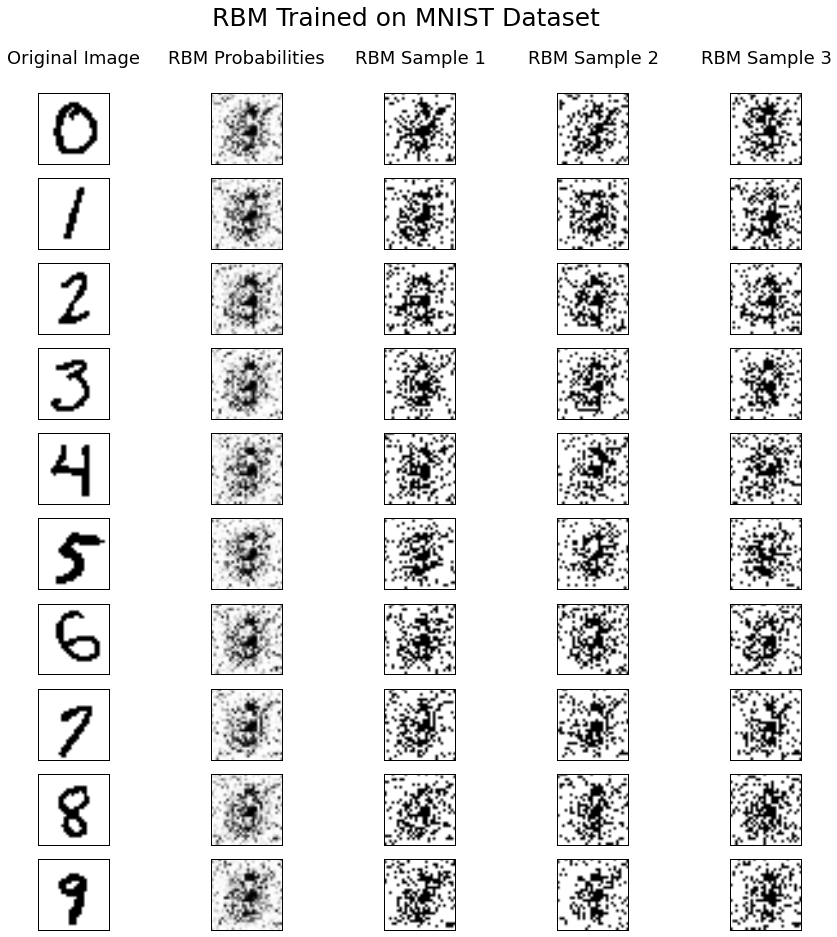

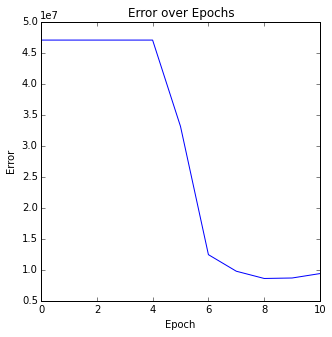

array([[ 0.08378323, -0.03508037, -0.03664955, ..., -0.014732  ,
        -0.03063255, -0.02558089],
       [-0.0500012 ,  0.17204243, -0.36235818, ...,  0.11580197,
         0.4055707 , -0.46636612],
       [-0.05008158,  0.10148981,  0.08141593, ..., -0.16130769,
         0.19652633, -0.3959308 ],
       ..., 
       [-0.05000109, -0.39532399,  0.10968398, ..., -0.28121588,
         0.32326257, -0.57345463],
       [-0.05163015,  0.32620842, -0.03749332, ..., -0.20118691,
        -0.42133562, -0.07899385],
       [-0.05038532, -0.03019971,  0.41102996, ..., -0.39197736,
         0.06272066, -0.49369599]])

In [8]:
# example visualization plot

rbm_and_plot(mnist_data_array, num_hidden=300, epochs=10, learning_rate=.1, persistent=True)

Layers:  300 Rate:  0.1 Epoch:  10 , Error:  9108302.2


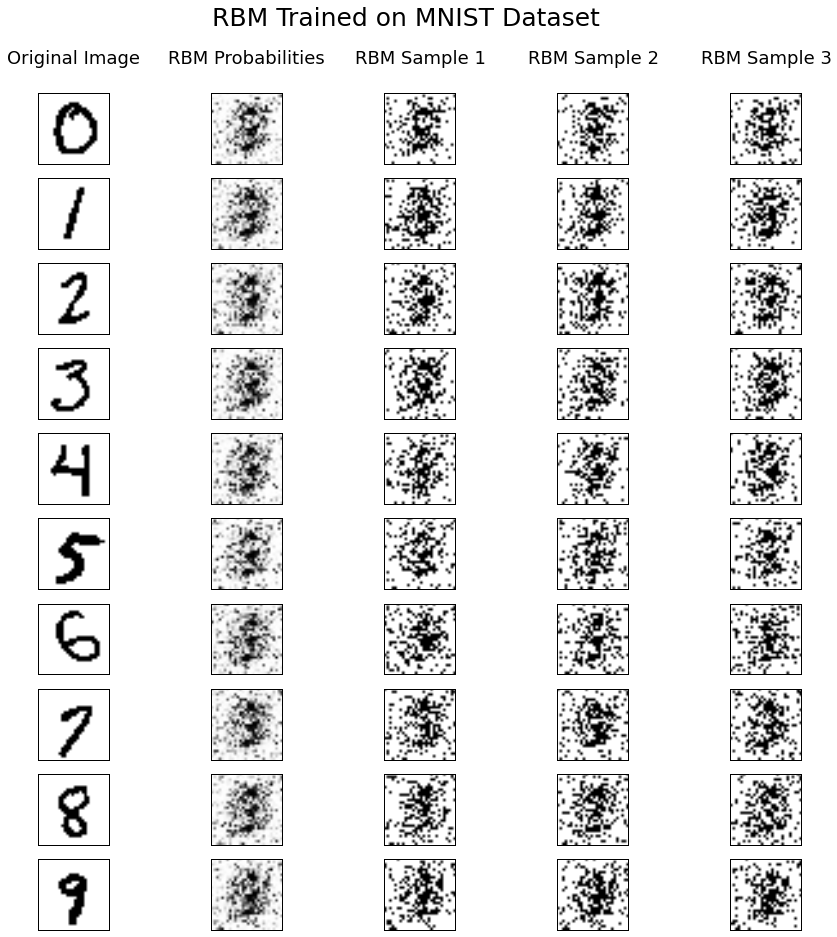

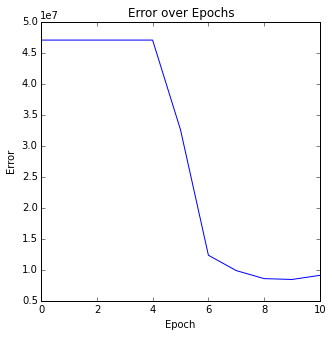

array([[ 0.08511162, -0.01654534, -0.00992223, ..., -0.02902126,
        -0.03405618, -0.03843133],
       [-0.05011999,  0.06879497, -0.22329768, ..., -0.41388889,
        -0.38090556,  0.127711  ],
       [-0.05004792, -0.03372312,  0.3459661 , ...,  0.0790994 ,
         0.13563573,  0.32901799],
       ..., 
       [-0.05000212,  0.37026711,  0.02966071, ...,  0.39987713,
        -0.42899865,  0.09512517],
       [-0.05000651, -0.27819962,  0.21166728, ..., -0.50956604,
        -0.20900039, -0.33804819],
       [-0.05006509,  0.38959318,  0.27852049, ...,  0.39698915,
         0.12706228, -0.40835971]])

In [10]:
# example visualization plot

rbm_and_plot(mnist_data_array, num_hidden=300, epochs=10, learning_rate=.1, persistent=True)

# Deep Belief Network

### Stacking RBMs to perform deep learning

In [22]:
class DBN(object):
    """
    Implementation of Deep Belief Network, made by stacking RBMs
    
    Inputs:
    data
    layer_nodes, an array that describes desired network architecture
    
    Example:
    [3, 4, 5, 3] will form a DBN with:
    - 3 unit visible layer
    - 4 unit hidden layer 
    - 5 unit hidden layer
    - 3 unit hidden layer
    
    number of epochs to train from
    learning rate, default set to 0.1
    unit, either "binary" or "continuous", default set to binary
    
    Outputs:
    set of weights
    """

    def __init__(self, data, layer_nodes, num_epochs, learning_rate=0.1, unit="binary"):
        
        self.data = data
        self.num_data = data.shape[0]
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.layer_nodes = layer_nodes
        self.num_layers = len(self.layer_nodes)
        self.unit = unit
        
        # List of stacked RBMs
        self.RBM_layer = range(0,len(self.layer_nodes)-1)  
        
        # List of messages 
        self.RBM_layer_messages = range(0,len(self.layer_nodes))  
        self.RBM_layer_messages[0] = self.data
        
    def _build(self):
        """
        Builds the DBN
        """
        
        for i in xrange(0,len(self.layer_nodes)-1):
            
            # create each RBM layer by creating separate RBM objects
            self.RBM_layer[i] = RBM(self.RBM_layer_messages[i], \
                                    self.layer_nodes[i], \
                                    self.layer_nodes[i+1], \
                                    self.num_epochs, \
                                    self.learning_rate, \
                                    self.unit)
            
            # train each RBM layer using RBM implementation of CDk
            down_probs, err = self.RBM_layer[i].CDk()  
            
            # create messages to pass between the layers
            self.RBM_layer_messages[i+1] = self.RBM_layer[i]._sample_h_given_v(self.RBM_layer_messages[i])
            
            # error
            print(i)
            print(self.RBM_layer_messages[i])
            print(down_probs[:,1:])
            error = np.sum((self.RBM_layer_messages[i] - down_probs[:,1:]) ** 2)
            #print("DBN Layer: ", i, ", DBN Error: ", error)
            
        return
    
    def _dbn_sample_v_given_h(self, h):  
        # h does not contain bias
        
        temp = h
        for i in xrange(len(self.layer_nodes)-2,-1,-1):
            temp = self.RBM_layer[i]._sample_v_given_h(temp)
        return temp
    
    def _dbn_sample_h_given_v(self, v):  
        # v does not contain bias
        
        temp = v
        for i in xrange(0,len(self.layer_nodes)-1):
            temp = self.RBM_layer[i]._sample_h_given_v_nontrain(temp)
        return temp


#### View some example output from DBN

In [23]:
visible_units = data_array.shape[1]
num_epochs = 10
learning_rate = 0.1

dbn_learner = DBN(data_array, [visible_units,50,20], num_epochs, learning_rate)
dbn_learner._build()

Layers:  50 Rate:  0.1 Epoch:  10 , Error:  6251683.64215
0
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[[ 0.05372379  0.1540914   0.11857136 ...,  0.23458685  0.2132965
   0.03983934]
 [ 0.07562701  0.51902175  0.05070752 ...,  0.16268114  0.17550924
   0.07844403]
 [ 0.04036826  0.35332802  0.24984723 ...,  0.30342067  0.19661747
   0.1134182 ]
 ..., 
 [ 0.00990864  0.21303618  0.18986867 ...,  0.0656016   0.1291091
   0.08899128]
 [ 0.04425068  0.0681778   0.18658616 ...,  0.40069221  0.12894384
   0.01990297]
 [ 0.05048112  0.05954092  0.08282334 ...,  0.09652144  0.05978842
   0.03664058]]
Layers:  20 Rate:  0.1 Epoch:  10 , Error:  1008325.58889
1
[[False  True  True ...,  True False  True]
 [False  True  True ...,  True False False]
 [ True False False ..., False  True  True]
 ..., 
 [ True False  True ..., False False  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  T

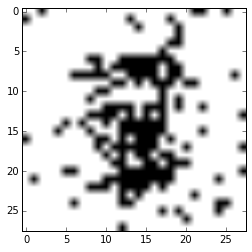

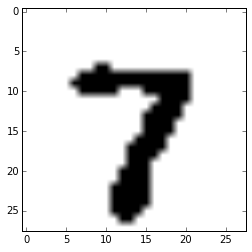

In [24]:
img = 44444

h = dbn_learner._dbn_sample_h_given_v(data_array[img])
v = dbn_learner._dbn_sample_v_given_h(h)

plt.imshow(v.reshape(28,28), cmap = 'Greys')
plt.show()

plt.imshow(data_array[img].reshape(28,28), cmap = 'Greys')
plt.show()

## Visualizing the DBN